# 배그 스팀 리뷰를 통한 감성분석
* https://mjdeeplearning.tistory.com/67
* https://github.com/MOONJOOYOUNG/DataScience/tree/master/Sentiment%20Analysis

### 준비

In [ ]:
## 준비 

#라이브러리
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import re
import collections
import itertools
!pip install lda
import lda
import requests
import csv
import time
import math
import operator
import numpy as np
import pandas as pd
from collections import defaultdict
from pandas import read_table
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

#구글 마운트
from google.colab import drive
drive._mount('/content/drive') 

     |████████████████████████████████| 351 kB 5.2 MB/s 
     |████████████████████████████████| 99 kB 12.2 MB/s 


### 전처리

In [ ]:
## 데이터 전처리 과정

# data csv 파일 가져오기.
data = pd.read_csv('/content/drive/MyDrive/bed_review_temp.csv', encoding='cp949')
data = data.dropna()

# df.dataframe 저장용 리스트 만들기.
data_list = []
for i in data['리뷰']:
    data_list.append(str(i))

# 한글영어숫자특수기호 남기기.
pre_list = []
for i in data_list:
    i = str(i)
    text = re.sub('[^ㄱ-ㅎ가-힣a-zA-Z0-9]',' ',i).strip()
    text = re.sub('[,]','',text)
    text = re.sub('  ','',text)
    if(text != ''):
        if(text[0] !='?'):
            pre_list.append(text)

# 불필요 어구 제거. 
# 한국어는 조사 접속사 제거하고 직접 불용어 사전 정의해서 제거해야 함
nnp_list = []
for i in pre_list:
    origin_words = nltk.word_tokenize(i)
    data_pos = nltk.pos_tag(origin_words)
    words_nnp = [word for word, pos in data_pos if pos in ['NN','NNP','VBG','JJ','JJS','JJR','RB','RBS','RBR']]
    nnp_list.append(words_nnp)

# 불필요 제거 어구 리스트 1차원 감소.
words_list = list(itertools.chain.from_iterable(nnp_list))

354

### 토픽 모델링
* LDA: 주어진 문서에 대하여 각 문서에 어떤 주제들이 존재하는지에 대한 확률모형
* (1) 문서 집합에서 얻은 분포로부터 토픽 추출
* (2) 해당 토픽에 해당하는 단어 추출

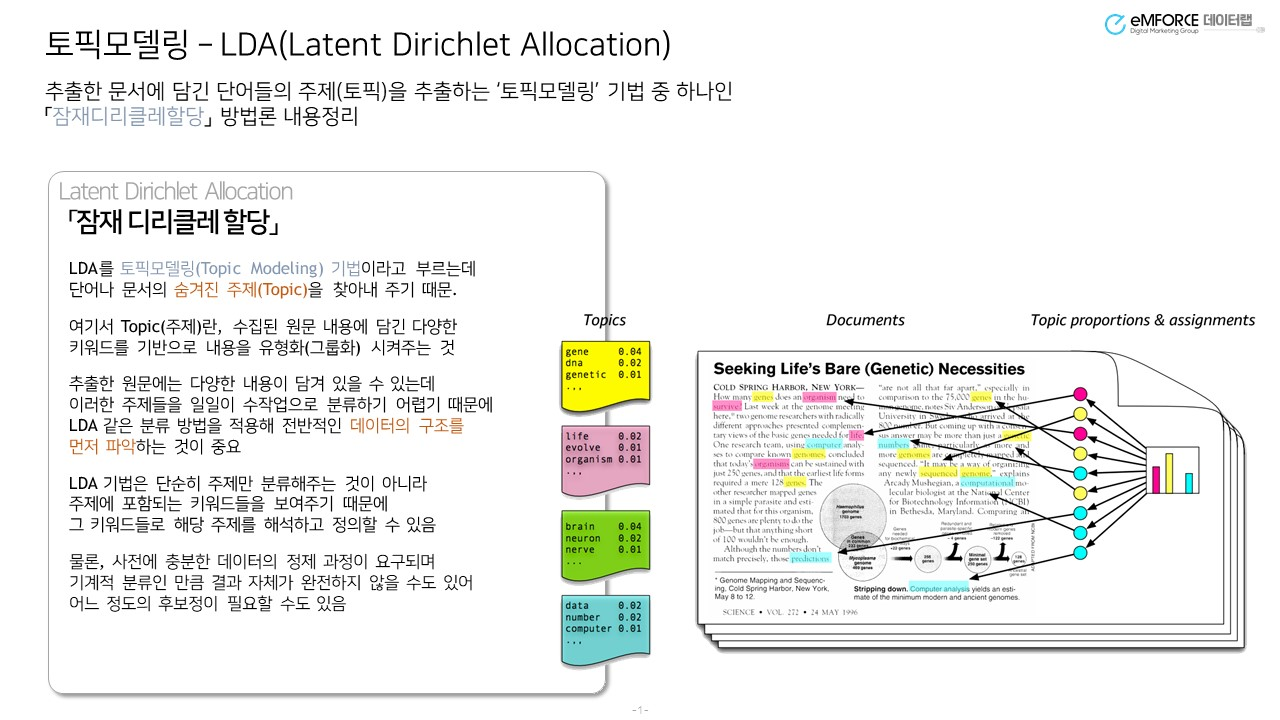

In [ ]:
## 토픽 모델링 과정

# WordCount
word_count = collections.Counter(words_list)
result = word_count.most_common(1000)
print(len(word_count))
print(result)

# Countervoctorzier & LDA
c_vetorizer = CountVectorizer(analyzer='word')
count = c_vetorizer.fit_transform(words_list)

model = lda.LDA(n_topics = 4, n_iter = 1000, random_state=1)
model.fit(count)

# LDA result
topic_vocab = c_vetorizer.get_feature_names()
topic_word = model.topic_word_
n_top_word = 100
dist = []
for i, topic_dist in enumerate(topic_word):
    dist.append(topic_dist)
    topic_words = np.array(topic_vocab)[np.argsort(topic_dist)][:-n_top_word:-1]
    print('Topic', i+1, topic_words)

### 나이브 베이즈 
* 긍부정 단어 모델링
* 리뷰 자체를 긍부정으로 나눠서 가져옴 -> __안되겠다!__

In [ ]:
## 나이브 베이지 과정

# 나이브 베이지안 모델
class NaiveBayesClassifier:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = []

    def count_words(self, training_set):
        # 학습데이터는 게임리뷰 본문(doc), 라벨(label)으로 구성
        # 나이브 베이지안 stopwords = 1이상의 값을 가지는 단어와 불필요 상위 단어.
        #stop_words = 'game','pubg','play','playing','time','gameplay','very','going','review','lul','experience','u','point','long','reason','pc','highly','community','everything','current','steam','too','this','next','playerunknown','in','all','pan','soon','anything','open','even','still','far','much','early','much','really','lot','ever','new','access','many','t','gmae','first','way','also','way','free','actually','back','someone','dont','something','nothing','LUL','instead','the','thing','a','bluehole','trying','already','almost','not','team','high','amount','away','able','and','always','everyone','year','to','day','guy','is','you','i','maybe','else','na','s','don','so','it','im','cant'
        counts = defaultdict(lambda : [0, 0])
        for doc, label in training_set:
            # 영화리뷰가 text일 때만 카운트
            if self.isNumber(doc) is False:
                # 리뷰를 띄어쓰기 단위로 토크나이징
                words = doc.split()                           
                # 토픽 모델링과 같은 전처리.
                data_pos = nltk.pos_tag(words)
                words_nnp = [word for word,pos in data_pos if pos in ['NN','NNP','VBG','JJ','JJS','JJR','RB','RBS','RBR']]
                words = [w for w in words_nnp if not w in stopwords.words('english')]
                
                for word in words:
                    text = str(word)
                    i = text.lower()
                    if(i not in stop_words):
                        # 라벨이 1이면 0값 지정
                        counts[i][0 if label == 1 else 1] += 1
        return counts
    # 예외 처리
    def isNumber(self, s):
        try:
            float(s)
            return True
        except ValueError:
            return False
    # 모델 결과 반환.
    def word_probabilities(self, counts, total_class0, total_class1, k):
        # 단어의 빈도수를 [단어, p(w|긍정), p(w|부정)] 형태로 반환
        return [(w,
                 (class0 + k) / (total_class0 + 2*k),
                 (class1 + k) / (total_class1 + 2*k))
                for w, (class0, class1) in counts.items()]

    def class0_probability(self, word_probs, doc):
        # input 띄어쓰기 처리
        docwords = doc.split()
        # 초기값은 모두 0으로 처리
        log_prob_if_class0 = log_prob_if_class1 = 0.0

        for word, prob_if_class0, prob_if_class1 in word_probs:
            
            # 만약 리뷰에 word가 나타나면 해당 단어가 나올 log 확률을 더해 줌
            if word in docwords:
                log_prob_if_class0 += math.log(prob_if_class0)
                log_prob_if_class1 += math.log(prob_if_class1)
            # 만약 리뷰에 word가 나타나지 않는다면 해당 단어가 나오지 않을 log 확률을 더해 줌. 
            # 나오지 않을 확률은 log(1-나올 확률)로 계산
            else:
                log_prob_if_class0 += math.log(1.0 - prob_if_class0)
                log_prob_if_class1 += math.log(1.0 - prob_if_class1)

        prob_if_class0 = math.exp(log_prob_if_class0)
        prob_if_class1 = math.exp(log_prob_if_class1)
        return prob_if_class0 / (prob_if_class0 + prob_if_class1)
    # 모델 학습
    def train(self, corpus):
        training_set = corpus

        # calss0 = 긍정리뷰 수 / class1 = 부정리뷰 수 
        num_class0 = 95000
        num_class1 = 95000

        # train
        word_counts = self.count_words(training_set)
        self.word_probs = self.word_probabilities(word_counts, num_class0, num_class1, self.k)
    # 모델 테스트 
    def classify(self, doc):
        return self.class0_probability(self.word_probs, doc)

# 긍정 리뷰 불러오기
trainfile_path=r'E:/unstruct/Merge_data_po.csv'
corpus = read_table(trainfile_path, sep=',', encoding='utf-8')
train_po = corpus[0:95000]
corpus_po = np.array(train_po)
# 부정 리뷰 불러오기
trainfile_path=r'E:/unstruct/Merge_data_ne.csv'
corpus = read_table(trainfile_path, sep=',', encoding='utf-8')
train_ne = corpus[0:95000]
corpus_ne = np.array(train_ne)
# 긍정 부정 리뷰 병합 베이지안 모델 input
nb_data = np.concatenate((corpus_po, corpus_ne))

# 모델 학습 -> *어차피 합쳐서 할거라면 긍부정 리뷰로 안나눠도 되나?
model = NaiveBayesClassifier()
model.train(nb_data)
# 긍정 단어 가중치로 딕셔너리 만들기
dict_p = {}
for i in model.word_probs:
    dict_p[i[0]] = i[1]
# 부정 단어 가중치로 딕셔너리 만들기    
dict_n = {}
for i in model.word_probs:
    dict_n[i[0]] = i[2]
# 각 딕셔너리 값을 내림차순 정렬
sort_dict_p = sorted(dict_p.items(), key=operator.itemgetter(1), reverse=True)
sort_dict_n = sorted(dict_n.items(), key=operator.itemgetter(1), reverse=True)
# 각 리뷰별 상위 단어 추출
for i in sort_dict_p[0:30]:
    print(i[0])
for i in sort_dict_n[0:30]:
    print(i[0])
# 나이브 베이지안 모델 테스트
a = 'Australian servers are here The Good Great graphicsPvp combat is responsive and balancedVariety of weapons attatchments armour and health pickups vehicles tooDevs that listen to the community feedbackThe Bad Typical bugs and glitches you d expect from an early access gamee g menu freezing after game The target area is a bit annoying it s hard to focus on killing when you re too busy trying to make it into the target area and not automatically killed within the time limitHalf of the time i recieve reward points they arent even credited to my accountPurchased the first crate for 700 coins and did not even receive my items Recommendations Maybe introduce other modes andor smaller areas on the mapE g Close quarters All in all this game has great potential and is off to a great startI m excited to see what the devs have in store for us'
model.classify(a)

# 네이버 플레이스 카테고리별 감성분석
* https://soyoung-new-challenge.tistory.com/46
* https://github.com/haesoly/estimate_review_of_restaurant


### 준비

In [ ]:
#구글 마운트
from google.colab import drive
drive._mount('/content/drive')

# 라이브러리 로딩
import pandas as pd
import numpy as np
import re
import os
import sys
import json

!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install konlpy
!pip install soynlp

from pykospacing import Spacing
from konlpy.tag import Kkma
from konlpy.tag import Okt
import soynlp

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import re
import collections
import itertools
!pip install lda
import lda
import requests
import csv
import time
import math
import operator
import numpy as np
import pandas as pd
from collections import defaultdict
from pandas import read_table
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

kkma = Kkma()
okt = Okt()

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-ry51oc6e
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-ry51oc6e
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* 전처리에 사용되는 라이브러리 로딩

In [ ]:
# # 파일을 사용하기 좋게 정리하기
# df = pd.read_csv('/content/drive/MyDrive/bed_review_temp.csv', encoding='cp949').dropna()
# temp_dict = {}
# temp_dict['user'] = df['닉네임']
# temp_dict['review'] = df['리뷰']

* 파일을 사용하기 좋게 딕셔너리 형태로 변환
* 닉네임은 user에 담고, 리뷰는 review에 담기

### 전처리

In [ ]:
# # 전처리 함수 
# def preprocessing(review):
#     total_review = ''
#     #인풋리뷰
#     for idx in range(len(review)):
#         r = review[idx]
#         #하나의 리뷰에서 문장 단위로 자르기
#         for sentence in kkma.sentences(r):
#             sentence = re.sub('([a-zA-Z])','',sentence)
#             sentence = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',sentence)
#             sentence = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',sentence)
#             if len(sentence) == 0:
#                 continue
#             if len(sentence) < 198:
#                 sentence = Spacing(sentence)
#             sentence += '. '
#             total_review += sentence
#     return total_review

- 문장단위로 리뷰를 나눈다
- 불용어를 제거한다 (영어, 자음, 모음, 특수문자)
- 잘못된 띄어쓰기 처리
- 문장 마지막에 마침표 추가

### 토픽 모델링

In [ ]:
# 토픽 모델링 
 
# data csv 파일 가져오기.
data = pd.read_csv('/content/drive/MyDrive/bed_review_temp.csv', encoding='utf-8')

# df.dataframe 저장용 리스트 만들기.
data_list = []
for i in data['리뷰내용']:
    data_list.append(str(i))

# 한글영어숫자특수기호 남기기.
pre_list = []
for i in data_list:
    i = str(i)
    text = re.sub('[^ㄱ-ㅎ가-힣a-zA-Z0-9]',' ',i).strip()
    text = re.sub('[,]','',text)
    text = re.sub('  ','',text)
    if(text != ''):
        if(text[0] !='?'):
            pre_list.append(text)

# 불필요 어구 제거. 
# 한국어는 조사 접속사 제거하고 직접 불용어 사전 정의해서 제거해야 함
nnp_list = []
for i in pre_list:
    origin_words = nltk.word_tokenize(i)
    data_pos = nltk.pos_tag(origin_words)
    words_nnp = [word for word, pos in data_pos if pos in ['NN','NNP','VBG','JJ','JJS','JJR','RB','RBS','RBR']]
    nnp_list.append(words_nnp)

# 불필요 제거 어구 리스트 1차원 감소.
words_list = list(itertools.chain.from_iterable(nnp_list))

# WordCount
word_count = collections.Counter(words_list)
result = word_count.most_common(1000)
print(len(word_count))
print(result)

# Countervoctorzier & LDA
c_vetorizer = CountVectorizer(analyzer='word')
count = c_vetorizer.fit_transform(words_list)

model = lda.LDA(n_topics = 4, n_iter = 5000, random_state=1)
model.fit(count)

# LDA result
topic_vocab = c_vetorizer.get_feature_names()
topic_word = model.topic_word_
n_top_word = 100
dist = []
for i, topic_dist in enumerate(topic_word):
    dist.append(topic_dist)
    topic_words = np.array(topic_vocab)[np.argsort(topic_dist)][:-n_top_word:-1]
    print('Topic', i+1, topic_words)

* 단어로 쪼개고 n개의 토픽으로 모델링
* 위 결과를 바탕으로 감성사전 구축
* 전처리의 문제인건지 아직 제대로 분류된 것 같진 않음 

### 감성사전

In [ ]:
# 감정분석을 위한 감정사전만들기
service_good_feature = {'서비스':['좋','친절','괜찮','최고','빠르','짱','훌륭','추천','감사','구수','최상','대박',
                               '훈훈','특별','개이득','최고','만족','세련','최고','감동'],
                        '사장':['친절','스윗','센스'],
                        '알바':['친절','스윗','센스'],
                        '직원': ['친절','스윗','센스'],
                        '일을':['잘','빠르게'],
                        '일도':['잘','빠르게'],
                        '서빙':['잘','빠르게']}

service_bad_feature = {'서비스': ['아쉽','최악','나쁘','느리','빡치','비추','별로','그냥','낙제','쏘다쏘다','엉망','실망','불친절','문제','컴플레인',
                               '거지','그닥','그다지','구려','불편','엉성','헬','개판'],
                       '알바':['불친절','똑바로','재수'],
                       '사장':['불친절','똑바로','재수'],
                       '직원':['불친절','똑바로','재수'],
                      '일을':['못','느리게','답답'],
                      '일도':['못','느리게', '천천히'],
                      '서빙':['못','느리게','천천히','답답']}

taste_good_feature = {'간':['맞','적절','딱','환상','담백'],
                      '음식':['깔끔'],
                      '맛':['있','좋','나다','최고']}

taste_bad_feature = {'간':['세','쎄','강하다','별로'],
                     '음식':['별로','쏘다쏘다','최악'],
                     '맛':['별로','최악']}

taste_good_emotion = ['고소','부드럽','신선','촉촉','싱싱','정갈','최고']

taste_bad_emotion = ['싱겁','느끼다하다','짜다','느끼다','짜다','딱딱하다','차갑다']

cost_good_feature = {'가격': ['괜찮','착하다','저렴','적당','싸다','좋다','합리적','훌륭','최고','만족','마음','든든','알맞다',
                            '무난','괜춘','최상','최상','굿','엄지','낮'],
                     '가성비':['괜찮','착하다','저렴','적당','싸다','좋다','합리적','훌륭','최고','만족','마음','든든','알맞다',
                            '무난','괜춘','최상','최상','굿','엄지'],
                     '양':['많','적당','푸짐하고','괜찮다','넉넉','충분','든든']
                     }

cost_bad_feature ={'가격': ['비싸','있다','나쁘','사악','비효율','높다','부담','아쉽','쏘다쏘다','별로','그닥','그다지','쎄','ㅎㄷㄷ','높','거품'],
                   '가성비':['별로'],
                   '양':['적다','작다','아쉽','적다','다소','별로'],
                   }

atmosphere_good_feature = {'분위기': ['좋','괜찮','조용','깔끔','적당','깡패','굉장','아담','완벽','아기자기','고급','최고','세련','만족','아늑','훌륭','예쁘','이쁘','짱',
                                   '심쿵','따뜻','깨끗','독특','매력','모던','취향저격','맘','마음','클래식','아름','인상적','귀엽','포근'], 
                           '인테리어': ['좋','괜찮','조용','깔끔','적당','깡패','굉장','아담','완벽','아기자기','고급','최고','세련','만족','아늑','훌륭','예쁘','이쁘','짱',
                                    '심쿵','따뜻','깨끗','독특','매력','모던','취향저격','맘','마음','클래식','아름','인상적','귀엽','포근']}

atmosphere_bad_feature = {'분위기': ['나쁘다','바쁘다','어수선하다','이상하다','촌스럽다','별로','부담스럽다','시끄럽','복잡' ],
                          '인테리어':[]}

visit_good_feature = {'의사':['있다','충만','백프로','백프롭','많','만땅','마구','그득','만점','넘침'],
                      '다시':['가다','오다','방문','찾다','가보다','한번','갈다','찾아가다','가야지','갈거다','방문하다보고',
                            '생각나다','방문한다면','와보고','재방문','접하다','간다면','갈다때가','먹다고프다','방문한다임','오자고','가기로','갈다생각이다','가면'],
                      '굳이':[]}

visit_bad_feature = {'의사':['글쎄'],
                     '굳이':['다시','많이','여기까지','줄서서','찾아','시키다','가다','찾다','여기','기다리다','줄을','사먹'],
                     '다시':[]}

negative_word_emotion = ['안','않','못','없','아닌','아니']

* 추출하고 싶은 카테고리를 정한다 : 내구성 / 가격 / 디자인 / 배송 
* 각 카테고리안에서 Key와 Value에 해당하는 감정사전을 생성한다.
* 예를 들어 가격이라면...
* 가격_good = 
              {'가격': ['싸다', '좋다', '착하다', '저렴', '적당'],
               '가성비': ['좋다', '최고', '굿', '만족']}

               
* 가격_bad = 
             {'가격': ['비싸다', '나쁘다', '창렬', '아깝', '부담'],
              '가성비': ['나쁘다', '구리다', '별로', '불만']}

* 이때 토픽 모델링을 이용하거나 노가다를 뛰어야 될 것 같다. (아님 내가 기존 사전을 못 찾는 건가..?)


In [ ]:
# 특징 키워드를 추출하는 함수
def get_feature_keywords(feature_keywords, review):
    feature_temp = []
    for keyword in feature_keywords:
        if re.findall(keyword, review):
            sub_list = ['게','고','음','며','데','만','도','면']
            
            for sub in sub_list:
                if sub+' ' in review:
                    review = re.sub(sub+' ', sub+',', review)
                
            a = re.findall(keyword +'+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+',review) # K한 한 한글
            b = re.findall(keyword + '+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+',review) # K 한 한글 
            c = re.findall('[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+\s+' + keyword +'[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+',review) # 한 K한글 예쁜 분위기가
                
            for ngram in a:
                t = ()
                feature_temp.append(t + (ngram,keyword))
            for ngram in b:
                t = ()
                feature_temp.append(t + (ngram,keyword))
            for ngram in c:
                t = ()
                feature_temp.append(t + (ngram,keyword))
                
    return feature_temp

* 특징 키워드가 속한 문장에서 뒤로 단어 + 키워드 + 단어 / 키워드 + 단어 + 단어를 추출한다.
* 가격_keyword = ['가격', '가성비']

In [ ]:
# 특징 키워드의 감정을 찾는 함수
def get_feature_emotions(feature_good_dict,feature_bad_dict, feature_temp):
    good_feature_emotion_list = []
    bad_feature_emotion_list = []
    
    for ngrams in feature_temp:
        keyword = ngrams[1]
        ngram = ngrams[0]
        is_bad_feature = None
        
        good_emotion_list = feature_good_dict[keyword]
        bad_emotion_list = feature_bad_dict[keyword]
        for emotion in good_emotion_list:
            if re.findall(emotion, ngram):
                is_bad_feature = False  
        for emotion in bad_emotion_list:
            if re.findall(emotion, ngram):
                is_bad_feature = True    
        for negative in negative_word_emotion:
            if re.findall(negative, ngram):
                if is_bad_feature == True:
                    is_bad_feature = False
                    break
                elif is_bad_feature == False:
                    is_bad_feature = True
                    break
                else:
                    is_bad_feature = True
                    break   
        if is_bad_feature:
            bad_feature_emotion_list.append(ngram)
        elif is_bad_feature == False:
            good_feature_emotion_list.append(ngram)
        else:
            pass
    return good_feature_emotion_list, bad_feature_emotion_list

* 위에서 추출한 키워드와 근처 단어들에서 감정사전을 확인


In [ ]:
# 맛에 대한 감정을 찾는 함수
def get_taste_emotion(taste_good_emotions, taste_bad_emotions):
    bad_taste_emotion_list = []
    good_taste_emotion_list = []
    for ngrams in taste_good_emotions:
        ngram = ngrams[0]
        is_bad_taste = False
        for negative in negative_word_emotion:
            if re.findall(negative,ngram):
                is_bad_taste = True
        if is_bad_taste:
            bad_taste_emotion_list.append(ngram)
        else:
            good_taste_emotion_list.append(ngram)
    
    for ngrams in taste_bad_emotions:
        ngram = ngrams[0]
        is_bad_taste = True
        for negative in negative_word_emotion:
            if re.findall(negative,ngram):
                is_bad_taste = False
        if is_bad_taste:
            bad_taste_emotion_list.append(ngram)
        else:
            good_taste_emotion_list.append(ngram)
            
    return good_taste_emotion_list, bad_taste_emotion_list

* 맛에 대한 긍정/부정 감정사전을 확인해서 점수를 측정

In [ ]:
# 최종 테스트 함수
# 음식점별

check_division = lambda x, y: y if y ==0 else round((x / float(y)),2)

for i, restaurant in enumerate(restaurant_review):
    restaurant_good_service_count = 0
    restaurant_bad_service_count = 0
    restaurant_good_atmosphere_count =0
    restaurant_bad_atmosphere_count =0
    restaurant_good_cost_count =0
    restaurant_bad_cost_count =0
    restaurant_good_visit_count = 0
    restaurant_bad_visit_count = 0
    restaurant_good_taste_count = 0
    restaurant_bad_taste_count = 0
    print(i, restaurant['_id'])
    reviews_list = refining(restaurant)
    for j, review in enumerate(reviews_list):
        service_temp = get_feature_keywords(service_good_feature.keys(), review)
        good_service,bad_service = get_feature_emotions(service_good_feature, service_bad_feature, service_temp)

        atmosphere_temp = get_feature_keywords(atmosphere_good_feature.keys(), review)
        good_atmosphere,bad_atmosphere = get_feature_emotions(atmosphere_good_feature, atmosphere_bad_feature, atmosphere_temp)

        cost_temp = get_feature_keywords(cost_good_feature.keys(), review)
        good_cost,bad_cost = get_feature_emotions(cost_good_feature, cost_bad_feature, cost_temp)

        visit_temp = get_feature_keywords(visit_good_feature.keys(), review)
        good_visit,bad_visit = get_feature_emotions(visit_good_feature, visit_bad_feature, visit_temp)

        taste_temp = get_feature_keywords(taste_good_feature.keys(), review)
        good_taste,bad_taste = get_feature_emotions(taste_good_feature, taste_bad_feature, taste_temp)
        taste_good_emotion_temp = get_feature_keywords(taste_good_emotion, review)
        taste_bad_emotion_temp = get_feature_keywords(taste_bad_emotion, review)
        good_taste2, bad_taste2 = get_taste_emotion(taste_good_emotion_temp,taste_bad_emotion_temp)
        good_taste.extend(good_taste2)
        bad_taste.extend(bad_taste2)

        if len(good_service) > len(bad_service):
            restaurant_good_service_count += 1
        elif len(good_service) < len(bad_service):
            restaurant_bad_service_count += 1
        else:
            pass
        
        if len(good_atmosphere) > len(bad_atmosphere):
            restaurant_good_atmosphere_count += 1
        elif len(good_atmosphere) < len(bad_atmosphere):
            restaurant_bad_atmosphere_count += 1
        else:
            pass
        
        if len(good_cost) > len(bad_cost):
            restaurant_good_cost_count += 1
        elif len(good_cost) < len(bad_cost):
            restaurant_bad_cost_count += 1
        else:
            pass
            
        if len(good_visit) > len(bad_visit):
            restaurant_good_visit_count += 1
        elif len(good_visit) < len(bad_visit):
            restaurant_bad_visit_count += 1
        else:
            pass
        
        if len(good_taste) > len(bad_taste):
            restaurant_good_taste_count += 1
        elif len(good_taste) < len(bad_taste):
            restaurant_bad_taste_count += 1
        else:
            pass
        
    TT = restaurant_good_service_count + restaurant_bad_service_count + restaurant_good_taste_count + restaurant_bad_taste_count + restaurant_good_atmosphere_count + restaurant_bad_atmosphere_count + restaurant_good_cost_count + restaurant_bad_cost_count
    
    if TT > 5:
        print('Total review count: {}'.format(len(reviews_list)))
        print('Good service: {}/{} = {}'.format(restaurant_good_service_count,restaurant_good_service_count + restaurant_bad_service_count,100*check_division(restaurant_good_service_count, restaurant_good_service_count + restaurant_bad_service_count)))
        print('Good atmosphere: {}/{} = {}'.format(restaurant_good_atmosphere_count,restaurant_good_atmosphere_count + restaurant_bad_atmosphere_count,100*check_division(restaurant_good_atmosphere_count,restaurant_good_atmosphere_count + restaurant_bad_atmosphere_count))) 
        print('Good cost: {}/{} = {}'.format(restaurant_good_cost_count,restaurant_good_cost_count + restaurant_bad_cost_count, 100*check_division(restaurant_good_cost_count,restaurant_good_cost_count + restaurant_bad_cost_count)))
        print('Good taste: {}/{} = {}'.format(restaurant_good_taste_count,restaurant_good_taste_count + restaurant_bad_taste_count,100*check_division(restaurant_good_taste_count,restaurant_good_taste_count + restaurant_bad_taste_count)))
        print('')

* 최종적으로 4개의 카테고리별 점수가 출력된다
* 감정키워드와 감정동사가 없는 경우는 그냥 pass 된다

# 정리
* 감성사전은 다는 아니더라도 어느 정도는 우리가 판단해서 구축해야될 것 같음 
* 감성점수는 해당 리뷰가 감성사전에서 등장한 count로 계산하는데 너무 단순하진 않나 걱정됨
* 그래서 일단은 전처리 코드만 정리해놓기로 함


### 전처리
1. 리뷰에서 영어표현, punctuation, 이모티콘은 모두 제거한다. (=한글 표현만 남긴다)
2. 띄어쓰기 변환기를 통해 띄어쓰기가 되어있지 않은 문장들을 제대로 변환한다.
3. 형태소 분석기를 통해 각각의 리뷰를 형태소 단위로 분리한다.
4. 한 글자로 되어있는 것 제거
5. 빈도수가 많은 순으로 정렬 후 의미없는 단어 제거(=불용어 제거)
6. 최소 빈도수 이하의 것들은 제거한다.
7. 잘못 분리된 의미있는 단어들을 찾아서 사용자 단어 사전에 추가 (ex. 디테일 => 디 + 테일로 분리됨)

In [9]:
# 0. 준비

# 라이브러리 불러오기
import pandas as pd
import numpy as np
import re
import os
import sys
import json

!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install konlpy
!pip install soynlp

from pykospacing import Spacing
from konlpy.tag import Kkma
from konlpy.tag import Okt
import soynlp

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import re
import collections
import itertools
!pip install lda
import lda
import requests
import csv
import time
import math
import operator
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from pandas import read_table
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# 데이터 불러오기
from google.colab import drive
drive._mount('/content/drive')
data = pd.read_csv('/content/drive/Shareddrives/컨퍼런스/성예슬/review_bed_4050.csv')

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-2flkdvsm
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-2flkdvsm
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 1. 한글 표현만 남기기
def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

#print('Before: ', data['리뷰내용'][0])
#print('After: ', extract_word(data['리뷰내용'][0]))

data['리뷰'] = data['리뷰내용'].apply(lambda x: extract_word(x))  

In [11]:
# 2. 띄어쓰기 고치기
spacing = Spacing()

#print('Before: ', data['리뷰'][0])
#print('After: ', spacing(data['리뷰'][0]))

data['리뷰'] = data['리뷰'].apply(lambda x: spacing(x))

In [12]:
# 3. 형태소 분석
# 일단은 기본적인 okt 이용 
okt = Okt()
words = " ".join(data['리뷰'].tolist())
words = okt.morphs(words, stem=True)

In [13]:
# 4. 한 글자 제거
remove_one_word = [x for x in words if len(x)>1]
len(remove_one_word)

frequent = Counter(remove_one_word).most_common()
frequent # 리뷰 데이터가 작아서 아직은 유의미하지 않음 

[('하다', 2906),
 ('좋다', 1454),
 ('배송', 1422),
 ('너무', 1024),
 ('있다', 908),
 ('침대', 817),
 ('기사', 738),
 ('자다', 678),
 ('같다', 640),
 ('보다', 634),
 ('설치', 598),
 ('친절하다', 538),
 ('튼튼하다', 503),
 ('오다', 491),
 ('매트리스', 490),
 ('들다', 470),
 ('없다', 465),
 ('생각', 430),
 ('않다', 412),
 ('디자인', 399),
 ('받다', 394),
 ('예쁘다', 375),
 ('되다', 373),
 ('해주다', 363),
 ('만족하다', 339),
 ('가격', 328),
 ('이다', 314),
 ('프레임', 310),
 ('으로', 300),
 ('구매', 290),
 ('깔끔하다', 286),
 ('걸리다', 277),
 ('사용', 249),
 ('마음', 247),
 ('제품', 242),
 ('하고', 239),
 ('냄새', 230),
 ('쓰다', 221),
 ('주문', 219),
 ('정도', 216),
 ('조금', 213),
 ('가다', 212),
 ('사이즈', 201),
 ('괜찮다', 193),
 ('넘다', 191),
 ('헤드', 183),
 ('주다', 183),
 ('이라', 183),
 ('부분', 181),
 ('많이', 180),
 ('정말', 179),
 ('소리', 172),
 ('사다', 172),
 ('맞다', 160),
 ('빠르다', 156),
 ('에서', 156),
 ('나다', 153),
 ('아니다', 151),
 ('그렇다', 147),
 ('조립', 146),
 ('기다리다', 146),
 ('사진', 141),
 ('협탁', 141),
 ('그래도', 139),
 ('오래', 139),
 ('나무', 138),
 ('진짜', 137),
 ('색상', 136),
 ('까지', 136),
 ('늦다',

In [14]:
# 5. 불용어 제거
# 불용어리스트 수정 필요
with open('/content/drive/MyDrive/stopwords_temp.txt', 'r') as f:
    list_file = f.readlines()
stopwords = list_file[0].split(",")
remove_stopwords = [x for x in remove_one_word if x not in stopwords]
len(remove_stopwords)

frequent = Counter(remove_stopwords).most_common()
frequent

[('하다', 2906),
 ('좋다', 1454),
 ('배송', 1422),
 ('너무', 1024),
 ('있다', 908),
 ('침대', 817),
 ('기사', 738),
 ('자다', 678),
 ('같다', 640),
 ('보다', 634),
 ('설치', 598),
 ('친절하다', 538),
 ('튼튼하다', 503),
 ('오다', 491),
 ('매트리스', 490),
 ('들다', 470),
 ('없다', 465),
 ('생각', 430),
 ('않다', 412),
 ('디자인', 399),
 ('받다', 394),
 ('예쁘다', 375),
 ('되다', 373),
 ('해주다', 363),
 ('만족하다', 339),
 ('가격', 328),
 ('이다', 314),
 ('프레임', 310),
 ('으로', 300),
 ('구매', 290),
 ('깔끔하다', 286),
 ('걸리다', 277),
 ('사용', 249),
 ('마음', 247),
 ('제품', 242),
 ('하고', 239),
 ('냄새', 230),
 ('쓰다', 221),
 ('주문', 219),
 ('정도', 216),
 ('조금', 213),
 ('가다', 212),
 ('사이즈', 201),
 ('괜찮다', 193),
 ('넘다', 191),
 ('헤드', 183),
 ('주다', 183),
 ('이라', 183),
 ('부분', 181),
 ('많이', 180),
 ('정말', 179),
 ('소리', 172),
 ('사다', 172),
 ('맞다', 160),
 ('빠르다', 156),
 ('에서', 156),
 ('나다', 153),
 ('아니다', 151),
 ('그렇다', 147),
 ('조립', 146),
 ('기다리다', 146),
 ('사진', 141),
 ('협탁', 141),
 ('그래도', 139),
 ('오래', 139),
 ('나무', 138),
 ('진짜', 137),
 ('색상', 136),
 ('까지', 136),
 ('늦다',

In [16]:
# 6. 최소 횟수 이하 단어 제거
minimum_count = 3
more_than_one_time = []
for i in tqdm(range(len(remove_stopwords))):
    tmp = remove_stopwords[i]
    if remove_stopwords.count(tmp) >= minimum_count:
        more_than_one_time.append(tmp)

100%|██████████| 54119/54119 [02:31<00:00, 356.38it/s]


In [ ]:
# 7. konlpy에 사용자 단어 추가
# https://haystar.tistory.com/11
# 아니면 mecab 이용

In [ ]:
# # 데이터 전처리(정리)
# def load_data(n):
#     basepath = '/content/drive/MyDrive/'
#     df = pd.read_csv(basepath+'/content/drive/MyDrive/bed_n_'+str(n)+'.csv')
#     df = df.dropna()
#     df = df.drop_duplicates()
#     df = df.reset_index(drop=True)
#     return df

# def load_stopwords():
#     with open('/content/drive/MyDrive/stopwords_temp.txt', 'r') as f:
#         list_file = f.readlines()
#     return list_file[0].split(",")

# def extract_word(text):
#     hangul = re.compile('[^가-힣]') 
#     result = hangul.sub(' ', text) 
#     return result

# def make_wordlist(reviews, stopwords): #reviews = " ".join(data['Review'].tolist())
#     print("리뷰들을 모아 분석하는 중입니다.....")
#     #정규표현식 적용
#     print("데이터 정제 중....")
#     words = extract_word(reviews)
#     #형태소 추출
#     print("형태소 추출 중....")
#     words = okt.morphs(words,stem=True)
#     #한글자 제거
#     print("한글자 제거 중....")
#     words = [x for x in words if len(x)>1 or x =='닉']
#     #불용어 제거
#     print("불용어 제거 중....")
#     words = [x for x in remove_one_word if x not in stopwords]
#     #최소횟수 미만 제거
#     print("의미있는 단어리스트 생성 중....")
#     time.sleep(1)
#     minimum_count = 3
#     final = []
#     for i in tqdm(range(len(words))):
#         tmp = words[i]
#         if words.count(tmp) >= minimum_count:
#             final.append(tmp)
#     return set(final) #조건을 만족하는 단어 리스트

# def preprocess(text, word_list):
#     text = extract_word(text)
#     okt = Okt()
#     text = okt.morphs(text, stem = True)
#     text = [x for x in text if x in word_list]
#     return text

### 토픽 모델링

In [17]:
# 토픽 모델링(그냥 한 번 해봄)

# WordCount
word_count = collections.Counter(more_than_one_time)
result = word_count.most_common(1000)
print(len(word_count))
print(result)

# Countervoctorzier & LDA
c_vetorizer = CountVectorizer(analyzer='word')
count = c_vetorizer.fit_transform(more_than_one_time)

model = lda.LDA(n_topics = 4, n_iter = 5000, random_state=1)
model.fit(count)

# LDA result
topic_vocab = c_vetorizer.get_feature_names()
topic_word = model.topic_word_
n_top_word = 100
dist = []
for i, topic_dist in enumerate(topic_word):
    dist.append(topic_dist)
    topic_words = np.array(topic_vocab)[np.argsort(topic_dist)][:-n_top_word:-1]
    print('Topic', i+1, topic_words)

INFO:lda:n_documents: 51414
INFO:lda:vocab_size: 1538
INFO:lda:n_words: 51414
INFO:lda:n_topics: 4
INFO:lda:n_iter: 5000


1538
[('하다', 2906), ('좋다', 1454), ('배송', 1422), ('너무', 1024), ('있다', 908), ('침대', 817), ('기사', 738), ('자다', 678), ('같다', 640), ('보다', 634), ('설치', 598), ('친절하다', 538), ('튼튼하다', 503), ('오다', 491), ('매트리스', 490), ('들다', 470), ('없다', 465), ('생각', 430), ('않다', 412), ('디자인', 399), ('받다', 394), ('예쁘다', 375), ('되다', 373), ('해주다', 363), ('만족하다', 339), ('가격', 328), ('이다', 314), ('프레임', 310), ('으로', 300), ('구매', 290), ('깔끔하다', 286), ('걸리다', 277), ('사용', 249), ('마음', 247), ('제품', 242), ('하고', 239), ('냄새', 230), ('쓰다', 221), ('주문', 219), ('정도', 216), ('조금', 213), ('가다', 212), ('사이즈', 201), ('괜찮다', 193), ('넘다', 191), ('헤드', 183), ('주다', 183), ('이라', 183), ('부분', 181), ('많이', 180), ('정말', 179), ('소리', 172), ('사다', 172), ('맞다', 160), ('빠르다', 156), ('에서', 156), ('나다', 153), ('아니다', 151), ('그렇다', 147), ('조립', 146), ('기다리다', 146), ('사진', 141), ('협탁', 141), ('그래도', 139), ('오래', 139), ('나무', 138), ('진짜', 137), ('색상', 136), ('까지', 136), ('늦다', 135), ('깔다', 133), ('느낌', 133), ('아주', 130), ('그냥', 130), ('아쉽다

INFO:lda:<0> log likelihood: -396434
INFO:lda:<10> log likelihood: -359661
INFO:lda:<20> log likelihood: -351409
INFO:lda:<30> log likelihood: -345724
INFO:lda:<40> log likelihood: -340899
INFO:lda:<50> log likelihood: -337705
INFO:lda:<60> log likelihood: -335112
INFO:lda:<70> log likelihood: -334300
INFO:lda:<80> log likelihood: -333088
INFO:lda:<90> log likelihood: -332340
INFO:lda:<100> log likelihood: -331552
INFO:lda:<110> log likelihood: -331285
INFO:lda:<120> log likelihood: -330797
INFO:lda:<130> log likelihood: -329901
INFO:lda:<140> log likelihood: -328904
INFO:lda:<150> log likelihood: -328085
INFO:lda:<160> log likelihood: -327512
INFO:lda:<170> log likelihood: -327002
INFO:lda:<180> log likelihood: -326922
INFO:lda:<190> log likelihood: -326405
INFO:lda:<200> log likelihood: -325317
INFO:lda:<210> log likelihood: -325043
INFO:lda:<220> log likelihood: -324888
INFO:lda:<230> log likelihood: -325254
INFO:lda:<240> log likelihood: -324473
INFO:lda:<250> log likelihood: -3247

Topic 1 ['하다' '기사' '같다' '설치' '않다' '디자인' '으로' '제품' '하고' '쓰다' '조금' '가격' '가다' '많이'
 '빠르다' '그래도' '색상' '깔다' '느낌' '아주' '가성' '시간' '공간' '맞추다' '구성' '되어다' '바닥' '높이'
 '크다' '다만' '빼다' '가구' '닦다' '놓다' '만원' '살짝' '돼다' '시키다' '고민' '들어가다' '심플' '하지만'
 '이나' '냄새' '지방' '작다' '거의' '빠지다' '아이' '저희' '써다' '이사' '여서' '보고' '아래' '교환'
 '어울리다' '딱이다' '옮기다' '바꾸다' '미리' '에는' '해보다' '호텔' '니까' '이에요' '처리' '금방' '다리다'
 '위치' '활용' '모두' '그런데' '견고하다' '필요하다' '설명' '모르다' '갈다' '무엇' '크게' '께서' '계속'
 '벙커' '신경' '이렇다' '묻다' '머리' '일정' '고객' '가루' '그래서' '불안하다' '에도' '살다' '건지다'
 '단단하다' '여러' '엘베' '책상']
Topic 2 ['좋다' '보다' '받다' '되다' '너무' '사용' '마음' '생각' '괜찮다' '넘다' '주다' '이라' '헤드' '부분'
 '냄새' '맞다' '에서' '아니다' '기다리다' '오래' '나무' '진짜' '까지' '감사하다' '엄청' '보이다' '배송비'
 '대비' '쓸다' '높다' '상품' '아직' '없이' '하나' '찾다' '만족스럽다' '틀다' '올리다' '지다' '그리고'
 '근데' '편하다' '흔들리다' '설치' '알다' '추천' '느리다' '드리다' '같이' '끄다' '나서다' '만에' '낮다'
 '때문' '날짜' '적당하다' '조절' '이랑' '완전' '분위기' '좋아하다' '마감' '리뷰' '힘들다' '그대로' '선택'
 '좁다' '지만' '방이' '사진' '중간' '색감' '자체' '넣다' '무겁다' '전체' '하루' '별로' '환기' '실물'
 '보람' '판이' '밝기' 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


* 데이터가 적어서 그런지 전처리가 제대로 안돼서 그런지 전반적으로 별로임


### 감성분석
1. 원하는 카테고리 별로 __감성사전__ 제작: 내구성/가격/디자인/배송 -> 여기서부터 막힘
2. 제작한 감성사전을 기반으로 크롤링한 데이터의 __감성분석__ 진행
3. 감성분석을 통해 해당 리뷰의 카테고리별 __감성점수__ 산출
4. 산출된 만족도를 반영한 __감성평점__ 재정의
* 근데 원래 처음에 도메인별 감성사전을 구축하려던건 영화 장르에 따라서 같은 단어가(ex. 무섭다) 다른 감성점수를 가져야 되니까?의 느낌에서 출발했었는데 지금은 그 느낌은 아닌거죠?! 
* 그냥 같은 리뷰 내에서도 속성별로 평가가 다를 수 있으니까 그걸 반영하기 위한 카테고리별 감성사전 구축인걸로? 그럼 최종 감성점수는 또 어떻게 반영할지 같이 고민해봐야될 것 같아여. 최종 감성점수를 결국 또 각 영역 점수를 합산해서 도출할거라면 이 과정이 의미 있을지 모르겠고 따로 쓴다면 어떤 식으로 활용할지 고민해봅시당

### 그 외 
1. Multi-Domain Sentiment Dataset v2.0
* https://paperswithcode.com/dataset/multi-domain-sentiment-dataset-v2-0
* 아마존 제품 도메인에 따른 리뷰 감성분석 -> 영어라 아쉽 
2. 리뷰의 의미적 토픽 분류를 적용한 감성 분석 모델
* https://www.koreascience.or.kr/article/JAKO202018955009127.pdf
* 토픽 모델링(LDA) -> 의미적 토픽 재분류(Word2Vec)
3. 한국어 감성분석, 감성 기반 추천 시스템 
* https://sig413.tistory.com/5
* 감성 분석을 어떻게 추천시스템에 반영할지 코드 참고
4. BERT를 사용한 다기준 관광객 추천시스템
* https://www.earticle.net/Article/A392618
* 우리가 하려는 것과 비슷
5. 호텔 예약 사이트 리뷰 분석을 통한 고객 맞춤형 호텔 추천 시스템
* https://www.youtube.com/watch?v=970DKSAzoBo
* 5분 짜리 프로젝트 발표 영상
